In [8]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
import seaborn as sns

In [10]:
df_raw = pd.read_pickle('USGS_raw_data.pickle')
df = df_raw.dropna(axis=1, thresh=365*5)

In [11]:
def plotfit(X,y,lr):
    
    plt.subplots(figsize=(10,10))
    ax = plt.subplot(2,2,3)
    plt.scatter(lr.predict(X),y,alpha=0.3,color='black')
    ax.set_xlabel('measured log(turbidity)')
    ax.set_ylabel('predicted log(turbidity)')
    ax.set_title('Measured vs. Predicted',fontweight='bold')
    ax = plt.subplot(2,1,1)
    plt.plot(pd.Series(lr.predict(X),index=y.index),'.')
    plt.plot(y,'.')
    ax.set_xlabel('year')
    ax.set_ylabel('log(turbidity)')
    ax.legend(['measured','predicted'])
    ax.set_title('Time Series Plot',fontweight='bold')
    ax = plt.subplot(2,2,4)
    ax.set_title('Residual Histogram',fontweight='bold')
    ax.set_xlabel('residual')
    ax.set_ylabel('count')
    plt.hist(lr.predict(X)-y,bins=20,color='#999999');

In [12]:
data = df.dropna().apply(np.log)
len(data)

1359

In [23]:
# apply log transformation to all variables
lr = LinearRegression()
data = df.dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
lr.fit(X,y)
print(lr.score(X,y))
#plotfit(X,y,lr)

0.795497681407


In [155]:
# Recursive Feature Elimination

from sklearn.feature_selection import RFE

lr = LinearRegression()
data = df.dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)

X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
# create the RFE model and select 10 attributes
rfe = RFE(lr, 80)
rfe = rfe.fit(X, y)
# # summarize the selection of the attributes
# print(rfe.support_)
# print(rfe.ranking_)

cols = X.columns[rfe.support_]
group = list(cols)
group.append('turbidity')
# sns.pairplot(df[[<insert the columns of your df here>]])
# sns.heatmap(df[group].corr())     #<---- will give you a good visualization of the correlation matrix

lr = LinearRegression()
data = df[group].dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
rfe = RFE(lr, 50)
rfe = rfe.fit(X, y)
cols = X.columns[rfe.support_]
group = list(cols)
group.append('turbidity')

# lr = LinearRegression()
# data = df[group].dropna().apply(np.log)
# data = data.replace([np.inf, -np.inf], np.nan)
# data = data.dropna(axis=1)
# X = data.drop(['turbidity'],axis=1)
# y = data['turbidity']
# rfe = RFE(lr, 30)
# rfe = rfe.fit(X, y)
# cols = X.columns[rfe.support_]
# group = list(cols)
# group.append('turbidity')

# lr = LinearRegression()
# data = df[group].dropna().apply(np.log)
# data = data.replace([np.inf, -np.inf], np.nan)
# data = data.dropna(axis=1)
# X = data.drop(['turbidity'],axis=1)
# y = data['turbidity']
# rfe = RFE(lr, 13)
# rfe = rfe.fit(X, y)
# cols = X.columns[rfe.support_]
# group = list(cols)
# group.append('turbidity')

lr = LinearRegression()
data = df[group].dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
lr.fit(X,y)
print(lr.score(X,y))
# plotfit(X,y,lr)

0.747234723047


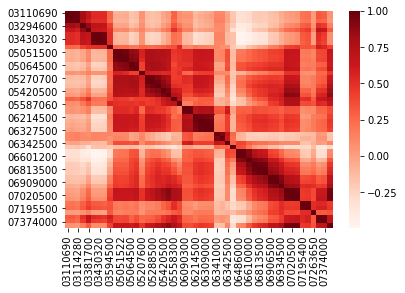

In [156]:
sns.heatmap(X.corr(),cmap='Reds')

In [157]:
# find groups of colinear features
d = {}
c = X.corr()
st_list = list(c.columns)
corr_thresh = 0.8

while len(st_list)>0:
    st_key = st_list[0]
    d[st_key] = []
    for st in st_list:
        if c.loc[st,st_key] > corr_thresh:
            d[st_key].append(st)
    for st in d[st_key]:
        st_list.remove(st)
d

{'03110690': ['03110690', '03111520', '03114280', '03294600'],
 '03381700': ['03381700'],
 '03430250': ['03430250', '03430320', '03431712'],
 '03594500': ['03594500'],
 '05051500': ['05051500', '05051522', '05054000', '05064500', '05082500'],
 '05207600': ['05207600'],
 '05270700': ['05270700', '05288500', '05331580', '05420500'],
 '05474500': ['05474500', '07010000', '07020500', '07022000', '07020850'],
 '05558300': ['05558300'],
 '05587060': ['05587060'],
 '06090300': ['06090300', '06090800'],
 '06214500': ['06214500', '06295000', '06309000', '06327500'],
 '06341000': ['06341000', '06342020'],
 '06342500': ['06342500'],
 '06441595': ['06441595'],
 '06486000': ['06486000', '06601200', '06610000'],
 '06807000': ['06807000', '06813500', '06818000'],
 '06906500': ['06906500', '06909000', '06934500'],
 '07195400': ['07195400', '07195500'],
 '07263650': ['07263650'],
 '07289000': ['07289000', '07374000']}

In [158]:
# test each station in each group with multiple stations
d_select = dict.fromkeys(d.keys())

for key in d.keys():
    if len(d[key])>1: # multiple stations
        r2 = 0
        for st in d[key]:
            to_remove = list(d[key])
            to_remove.remove(st)
            lr = LinearRegression()
            Xnew = X.drop(to_remove,axis=1)
            lr.fit(Xnew,y)
            if lr.score(Xnew,y)>r2:
                r2 = lr.score(Xnew,y)
                d_select[key] = (st,r2)
d_select

{'03110690': ('03111520', 0.74580980387708484),
 '03381700': None,
 '03430250': ('03431712', 0.74207418579360762),
 '03594500': None,
 '05051500': ('05064500', 0.73949127859907438),
 '05207600': None,
 '05270700': ('05270700', 0.74442984849540683),
 '05474500': ('07020850', 0.73245630810890461),
 '05558300': None,
 '05587060': None,
 '06090300': ('06090300', 0.74078609440435494),
 '06214500': ('06214500', 0.74348274186750229),
 '06341000': ('06342020', 0.74537837768247983),
 '06342500': None,
 '06441595': None,
 '06486000': ('06610000', 0.74572483553558699),
 '06807000': ('06818000', 0.74431203750789454),
 '06906500': ('06909000', 0.74629871891349808),
 '07195400': ('07195500', 0.74546242865576218),
 '07263650': None,
 '07289000': ('07374000', 0.74570827523293071)}

In [159]:
selected = []
for key in d_select.keys():
    if d_select[key] is None:
        selected.append(key)
    else:
        selected.append(d_select[key][0])

print(selected)

['03111520', '03381700', '03431712', '03594500', '05064500', '05207600', '05270700', '07020850', '05558300', '05587060', '06090300', '06214500', '06342020', '06342500', '06441595', '06610000', '06818000', '06909000', '07195500', '07263650', '07374000']


In [160]:
lr = LinearRegression()
selected.append('turbidity')
data = df[selected].dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
lr.fit(X,y)
lr.score(X,y)

0.67302985739144738

In [161]:
len(selected)

22

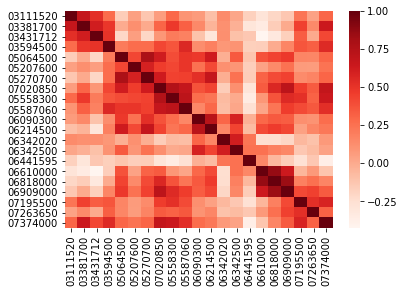

In [162]:
sns.heatmap(X.corr(),cmap='Reds')

In [128]:
Xsm = sm.add_constant(X)
# Create your model and
# Fit your model to your training set
smfit = sm.OLS(y,Xsm).fit()
smfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              turbidity   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     193.5
Date:                Wed, 31 Jan 2018   Prob (F-statistic):               0.00
Time:                        22:18:00   Log-Likelihood:                -884.76
No. Observations:                1587   AIC:                             1800.
Df Residuals:                    1572   BIC:                             1880.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.0606      2.304    -16.516      0.000     -42.581     -33.541
03111520      -0.1251      0.077     -1.630      0.103      -0.276       0.025
03431712       0.3613      0.141      2.569      0.010       0.085       0.637
03594500       1.2110      0.383      3.160      0.002       0.459       1.963
05207600       0.2582      0.027      9.539      0.000       0.205       0.311
05288500       0.0455      0.025      1.815      0.070      -0.004       0.095
07022000       0.8205      0.115      7.159      0.000       0.596       1.045
06090300       0.1153      0.053      2.159      0.031       0.011       0.220
06342020       1.8078      0.227      7.954      0.000       1.362       2.254
06342500      -0.4668      0.084     -5.576      0.000      -0.631      -0.303
06441595       3.6758      0.628      5.850      0.000       2.443       4.908
06486000       0.2290      0.070      3.278      0.001       0.092       0.366
06818000      -0.0389      0.051     -0.757      0.449      -0.140       0.062
07374000       0.9812      0.038     25.757      0.000       0.906       1.056
07020850      -1.1896      0.140     -8.505      0.000      -1.464      -0.915
==============================================================================
Omnibus:                        7.240   Durbin-Watson:                   0.139
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                7.159
Skew:                          -0.157   Prob(JB):                       0.0279
Kurtosis:                       3.099   Cond. No.                     6.61e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""